In [1]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.9 MB/s eta 0:00:00


In [2]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.8 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
import random
import os
import warnings
import easydict
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [ ]:
# train_df = train_df[train_df['price(원/kg)'] != 0]

# 함수 정의

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

# 시계열 특성 사용

In [6]:
#시계열 특성을 학습에 반영하기 위해 timestamp를 월, 일, 시간으로 나눕니다
train_df['year'] = train_df['timestamp'].apply(lambda x : int(x[0:4]))
train_df['month'] = train_df['timestamp'].apply(lambda x : int(x[5:7]))
train_df['day'] = train_df['timestamp'].apply(lambda x : int(x[8:10]))

test_df['year'] = test_df['timestamp'].apply(lambda x : int(x[0:4]))
test_df['month'] = test_df['timestamp'].apply(lambda x : int(x[5:7]))
test_df['day'] = test_df['timestamp'].apply(lambda x : int(x[8:10]))

# 과일 종류별로 데이터 분리

In [7]:
def classify_item(x):
    item=None
    #x=str(x)
    if 'TG' in x:
        item='TG'
    elif 'BC' in x:
        item='BC'
    elif 'CR' in x:
        item='CR'
    elif 'CB' in x:
        item='CB'
    elif 'RD' in x:
        item='RD'
    return item
train_df['item']=train_df.apply(lambda x: classify_item(x['ID']),axis=1)
test_df['item']=test_df.apply(lambda x: classify_item(x['ID']),axis=1)


# 학습에 사용할 변수 정의

In [8]:
# 학습에 사용하지 않을 변수들을 제거
train_X = train_df.drop(columns=['ID', 'timestamp', 'supply(kg)', 'price(원/kg)'])
train_Y = train_df[['price(원/kg)']]

test_X = test_df.drop(columns=['ID', 'timestamp'])

In [9]:
train_df.reset_index()

,index,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day
0,0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1
1,1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2
2,2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3
3,3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4
4,4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5
...,...,...,...,...,...,...,...,...,...,...,...
59392,59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,27
59393,59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,28
59394,59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,1
59395,59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,2


In [10]:
train_df

,ID,timestamp,item,corporation,location,supply(kg),price(원/kg),year,month,day
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.0,0.0,2019,1,1
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.0,0.0,2019,1,2
2,TG_A_J_20190103,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3
3,TG_A_J_20190104,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4
4,TG_A_J_20190105,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5
...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,452440.0,468.0,2023,2,27
59393,RD_F_J_20230228,2023-02-28,RD,F,J,421980.0,531.0,2023,2,28
59394,RD_F_J_20230301,2023-03-01,RD,F,J,382980.0,574.0,2023,3,1
59395,RD_F_J_20230302,2023-03-02,RD,F,J,477220.0,523.0,2023,3,2


test에는 supply(kg)이 없음

In [11]:
train_Y

,price(원/kg)
0,0.0
1,0.0
2,1728.0
3,1408.0
4,1250.0
...,...
59392,468.0
59393,531.0
59394,574.0
59395,523.0


# 수치형 스케일링

In [12]:
list(train_X.columns)

['item', 'corporation', 'location', 'year', 'month', 'day']

In [13]:
list(test_X.columns)

['item', 'corporation', 'location', 'year', 'month', 'day']

In [14]:
no_category_cols = []
category_cols = list(train_X.columns)

train_no_category = train_X[no_category_cols]
train_category = train_X[category_cols]

train_no_category.shape, train_category.shape

((59397, 0), (59397, 6))

In [15]:
no_category_cols = []
category_cols = list(test_X.columns)

test_no_category = test_X[no_category_cols]
test_category = test_X[category_cols]

test_no_category.shape, test_category.shape

((1092, 0), (1092, 6))

In [ ]:
'''# 스케일링 적용할 컬럼 선언
scaling_cols = ['supply(kg)']

# 수치형 데이터 프레임에서 스케일링 적용할 컬럼이 포함된 데이터 프레임 생성
train_scaling = train_no_category[scaling_cols]
#test_scaling = test_no_category[scaling_cols]

print(f'{train_scaling.shape}')# / {test_scaling.shape}')
train_scaling.head(3)'''

"# 스케일링 적용할 컬럼 선언\nscaling_cols = ['supply(kg)']\n\n# 수치형 데이터 프레임에서 스케일링 적용할 컬럼이 포함된 데이터 프레임 생성\ntrain_scaling = train_no_category[scaling_cols]\n#test_scaling = test_no_category[scaling_cols]\n\nprint(f'{train_scaling.shape}')# / {test_scaling.shape}')\ntrain_scaling.head(3)"

In [ ]:
'''from sklearn.preprocessing import StandardScaler'''

'from sklearn.preprocessing import StandardScaler'

In [ ]:
'''# 인스턴스 생성
std = StandardScaler()'''

'# 인스턴스 생성\nstd = StandardScaler()'

In [ ]:
'''std.fit(train_scaling)'''

'std.fit(train_scaling)'

In [ ]:
'''# 반영
X_train_scaled = std.transform(train_scaling)
X_test_scaled = std.transform(test_scaling)'''

'# 반영\nX_train_scaled = std.transform(train_scaling)\nX_test_scaled = std.transform(test_scaling)'

In [ ]:
'''X_train_scaled.shape, X_test_scaled.shape'''

'X_train_scaled.shape, X_test_scaled.shape'

In [ ]:
'''train_scaling.shape, test_scaling.shape'''

'train_scaling.shape, test_scaling.shape'

# 수치형, 범주형 합치기

In [16]:
_train_encoded = pd.DataFrame()
_test_encoded = pd.DataFrame()

for col in category_cols:
  _encoder = ce.OneHotEncoder(use_cat_names=True)
  _encoder.fit(train_category[col])
  _encoded = _encoder.transform(train_category[col])
  _train_encoded = pd.concat([_train_encoded, _encoded], axis=1)

  _encoded = _encoder.transform(test_category[col])
  _test_encoded = pd.concat([_test_encoded, _encoded], axis=1)

In [17]:
train_encoded = pd.concat([train_no_category, _train_encoded], axis=1)
train_encoded.shape

(59397, 16)

In [18]:
train_encoded

,item_TG,item_CR,item_CB,item_RD,item_BC,corporation_A,corporation_B,corporation_C,corporation_D,corporation_E,corporation_F,location_J,location_S,year,month,day
0,1,0,0,0,0,1,0,0,0,0,0,1,0,2019,1,1
1,1,0,0,0,0,1,0,0,0,0,0,1,0,2019,1,2
2,1,0,0,0,0,1,0,0,0,0,0,1,0,2019,1,3
3,1,0,0,0,0,1,0,0,0,0,0,1,0,2019,1,4
4,1,0,0,0,0,1,0,0,0,0,0,1,0,2019,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,0,0,0,1,0,0,0,0,0,0,1,1,0,2023,2,27
59393,0,0,0,1,0,0,0,0,0,0,1,1,0,2023,2,28
59394,0,0,0,1,0,0,0,0,0,0,1,1,0,2023,3,1
59395,0,0,0,1,0,0,0,0,0,0,1,1,0,2023,3,2


In [19]:
test_encoded = pd.concat([test_no_category, _test_encoded], axis=1)
test_encoded.shape

(1092, 16)

In [20]:
train_target = train_Y
train_features = train_encoded

train_features.shape, train_target.shape

((59397, 16), (59397, 1))

# K-Fold

In [109]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn import svm
from sklearn import datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV

In [110]:
# 교차 검증
skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)

## DecisionTree

In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
from sklearn.metrics import mean_squared_error

model = DecisionTreeClassifier(random_state=42)

n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # 학습
    model.fit(train_x, train_y)
    valid_pred = model.predict(valid_x)  # 예측값

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified Stratified K-Fold RMSE: 1490.747358531853
2 번째 Stratified Stratified K-Fold RMSE: 1470.9975012167283
3 번째 Stratified Stratified K-Fold RMSE: 1471.6421002788454
4 번째 Stratified Stratified K-Fold RMSE: 1532.47823259817
5 번째 Stratified Stratified K-Fold RMSE: 1547.8033734805836
6 번째 Stratified Stratified K-Fold RMSE: 1482.5813089031033
--------------------------------------------------
교차 검증 RMSE: 1499.374979168214


## XGBoost

### model 1

In [111]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [112]:
hp = {
    "random_state" : 42
}

model = XGBRegressor(**hp)
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1144.3445014268145
2 번째 Stratified K-Fold RMSE: 1144.9562946613496
3 번째 Stratified K-Fold RMSE: 1111.4488557161383
4 번째 Stratified K-Fold RMSE: 1152.2760625711733
5 번째 Stratified K-Fold RMSE: 1160.4996303757937
6 번째 Stratified K-Fold RMSE: 1180.6636597083707
--------------------------------------------------
교차 검증 RMSE: 1149.0315007432735


### model 2

In [113]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
model = XGBRegressor(**hp)

In [114]:
n_iter=6 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(200,1200,50, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

-1033.9780658261245

In [115]:
best_params = rs1.best_params_
best_params

{'n_estimators': 1118, 'max_depth': 7, 'learning_rate': 0.1}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

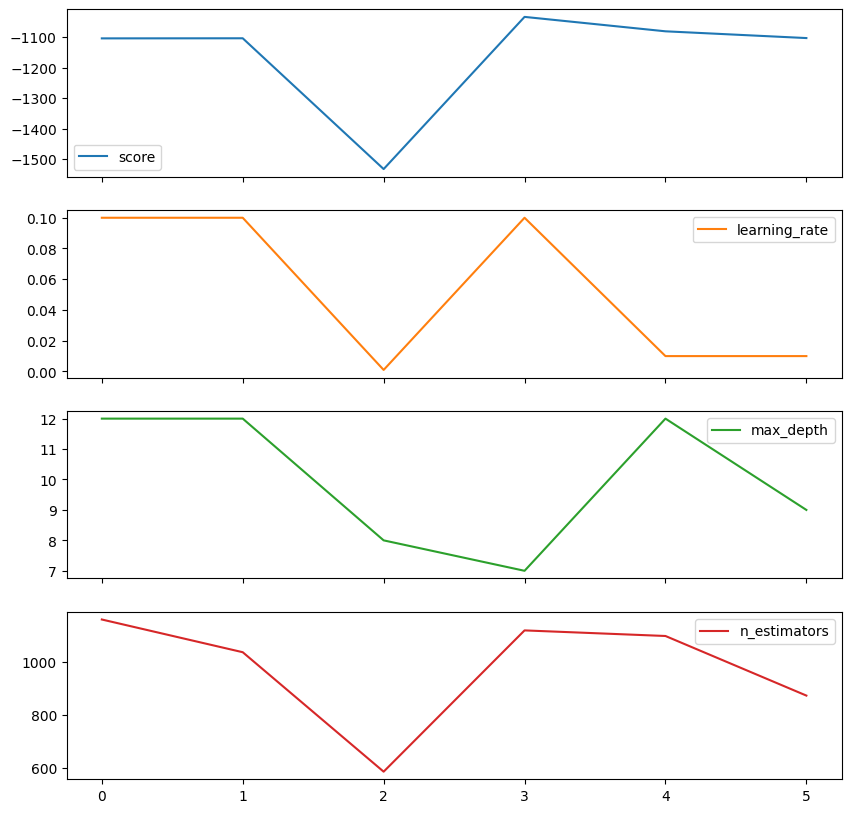

In [116]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [117]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [118]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
best_mode = XGBRegressor(**hp)

In [119]:
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1139.9807709623733
2 번째 Stratified K-Fold RMSE: 1158.4771900348048
3 번째 Stratified K-Fold RMSE: 1124.838688625251
4 번째 Stratified K-Fold RMSE: 1162.50970861524
5 번째 Stratified K-Fold RMSE: 1160.8171243571069
--------------------------------------------------
교차 검증 RMSE: 1149.324696518955


## Light GBM

### model 0

In [133]:
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import mean_squared_error

In [134]:
hp= {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',  # 회귀 모델의 성능 측정 메트릭 (Root Mean Squared Error)
    'num_leaves': 31,
    'learning_rate': 0.05,
    'verbose' : -1
}
model = LGBMRegressor(**hp)
n_iter = 0
accuracy_lst = []
rmse_lst = []
for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  tr_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  tr_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(tr_x, tr_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1204.7237958886394
2 번째 Stratified K-Fold RMSE: 1227.1813551069872
3 번째 Stratified K-Fold RMSE: 1201.877105452074
4 번째 Stratified K-Fold RMSE: 1233.8874647750151
5 번째 Stratified K-Fold RMSE: 1232.1132498723193
--------------------------------------------------
교차 검증 RMSE: 1219.956594219007


In [135]:
model = LGBMRegressor(**hp)
n_iter=3 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(2,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(1000,2000,20, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -0.8, 20)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=3)
# 학습 (best hp 조합 찾기)
rs1.fit(train_features, train_target)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


-1124.4166215382947

In [136]:
best_params = rs1.best_params_
best_params

{'n_estimators': 1842, 'max_depth': 12, 'learning_rate': 0.02451735887979288}

In [137]:
best_params.keys

<function dict.keys>

In [138]:
hp= {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',  # 회귀 모델의 성능 측정 메트릭 (Root Mean Squared Error)
    'num_leaves': 31,
    #'learning_rate': 0.05,
    'verbose' : -1,
    'n_estimators': 1473, 'max_depth': 7, 'learning_rate': 0.032008340465997674
}
model = LGBMRegressor(**hp)
n_iter = 0
accuracy_lst = []
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  tr_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  tr_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(tr_x, tr_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1139.4789236208585
2 번째 Stratified K-Fold RMSE: 1153.908641811846
3 번째 Stratified K-Fold RMSE: 1122.4822330564618
4 번째 Stratified K-Fold RMSE: 1165.8001149460642
5 번째 Stratified K-Fold RMSE: 1166.0887342440908
--------------------------------------------------
교차 검증 RMSE: 1149.5517295358645


### model 1

In [54]:
hp = {
    "random_state" : 42,
    'verbose' : -1
}
model = LGBMRegressor(**hp)
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1181.7864398364793
2 번째 Stratified K-Fold RMSE: 1185.2396350639333
3 번째 Stratified K-Fold RMSE: 1163.1372953865432
4 번째 Stratified K-Fold RMSE: 1205.7016217904113
5 번째 Stratified K-Fold RMSE: 1207.2764085684187
6 번째 Stratified K-Fold RMSE: 1219.2778261883077
--------------------------------------------------
교차 검증 RMSE: 1170.561315114076


### model 2

In [55]:
hp = {
    "random_state" : 42,
    "verbose": -1, # 로그
}
model = LGBMRegressor(**hp)

In [59]:
n_iter=10 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(400,3000,50, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

-1046.2620488282212

In [60]:
best_params = rs1.best_params_
best_params

{'n_estimators': 2204, 'max_depth': 12, 'learning_rate': 0.1}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

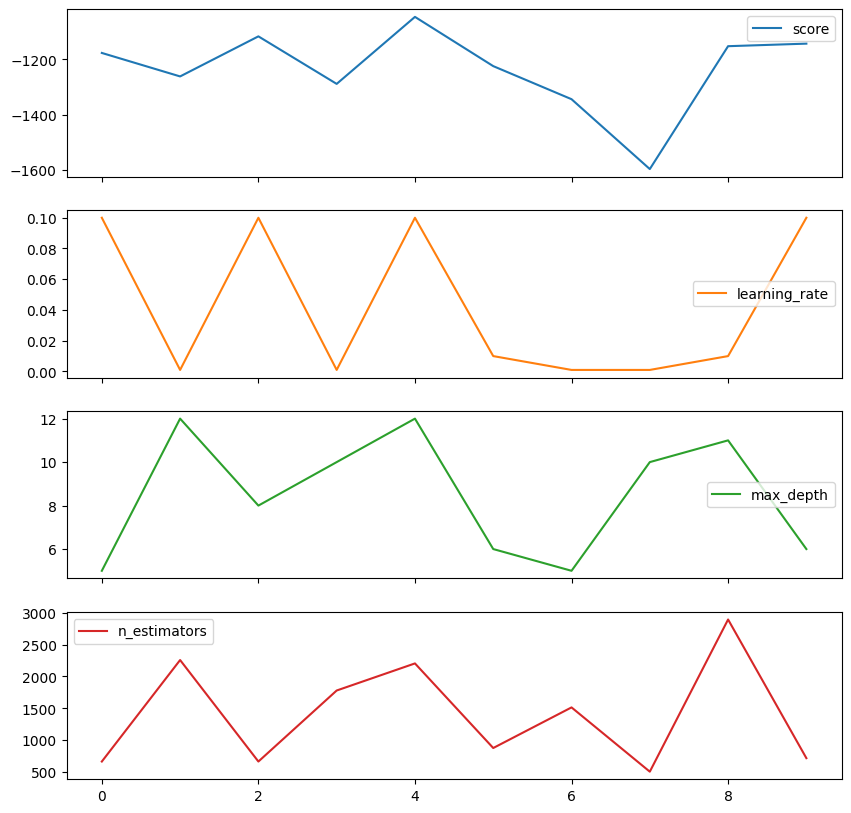

In [61]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [62]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [63]:
best_params['random_state'] = 42
best_params['verbose'] = -1

# best 모델 인스턴스 생성(정의)
best_mode = LGBMRegressor(**best_params)

In [64]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1183.5800031020576
2 번째 Stratified K-Fold RMSE: 1199.2767709018467
3 번째 Stratified K-Fold RMSE: 1176.5316833784498
4 번째 Stratified K-Fold RMSE: 1206.8214223234947
5 번째 Stratified K-Fold RMSE: 1208.220070835284
--------------------------------------------------
교차 검증 RMSE: 1177.715631288826


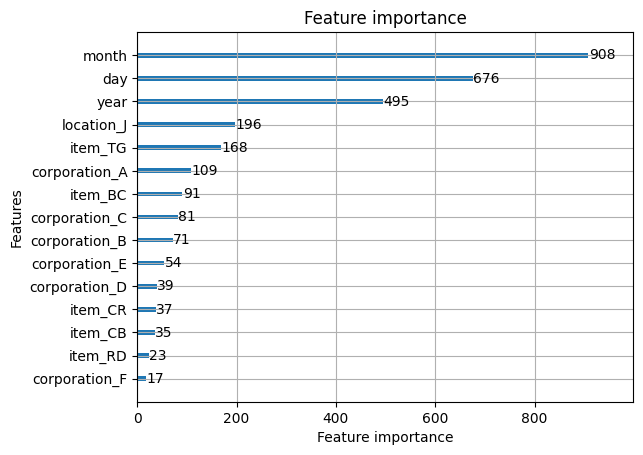

In [65]:
plot_importance(model)
plt.show()

## catboost

### model 1

In [139]:
from catboost import CatBoostRegressor

In [140]:
hp = {
    "random_state" : 42,
    "verbose" : 0 # 부스팅 단계 출력 안보이게 하기
}
model = CatBoostRegressor(**hp)
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1160.4498879620996
2 번째 Stratified K-Fold RMSE: 1174.3370134919671
3 번째 Stratified K-Fold RMSE: 1148.7386710385438
4 번째 Stratified K-Fold RMSE: 1187.6263061825628
5 번째 Stratified K-Fold RMSE: 1185.4321890434246
--------------------------------------------------
교차 검증 RMSE: 1160.434271539792


### model 2

In [68]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
model = CatBoostRegressor(**hp)

In [75]:
n_iter=10 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,15,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(10,1000,10, dtype = int), # 부스팅 단계수
    "learning_rate" : np.logspace(-3, -1, 3)
}

# HPO 인스턴스 생성
rs1=RandomizedSearchCV(model, hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

-1077.062055399124

In [76]:
best_params = rs1.best_params_
best_params

{'n_estimators': 670, 'max_depth': 10, 'learning_rate': 0.1}

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

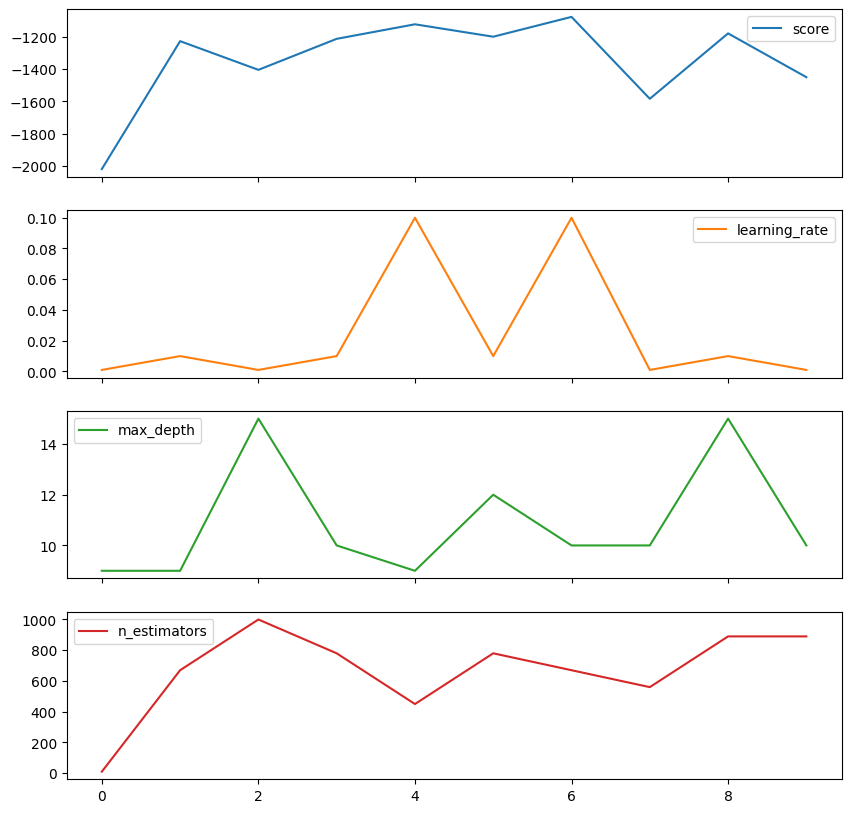

In [77]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_learning_rate'].data,
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'learning_rate', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [78]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [79]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
best_mode = CatBoostRegressor(**best_params)

In [80]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1160.4498879620996
2 번째 Stratified K-Fold RMSE: 1174.3370134919671
3 번째 Stratified K-Fold RMSE: 1148.7386710385438
4 번째 Stratified K-Fold RMSE: 1187.6263061825628
5 번째 Stratified K-Fold RMSE: 1185.4321890434246
--------------------------------------------------
교차 검증 RMSE: 1174.7161854708074


Text(0.5, 1.0, 'Feature Importance')

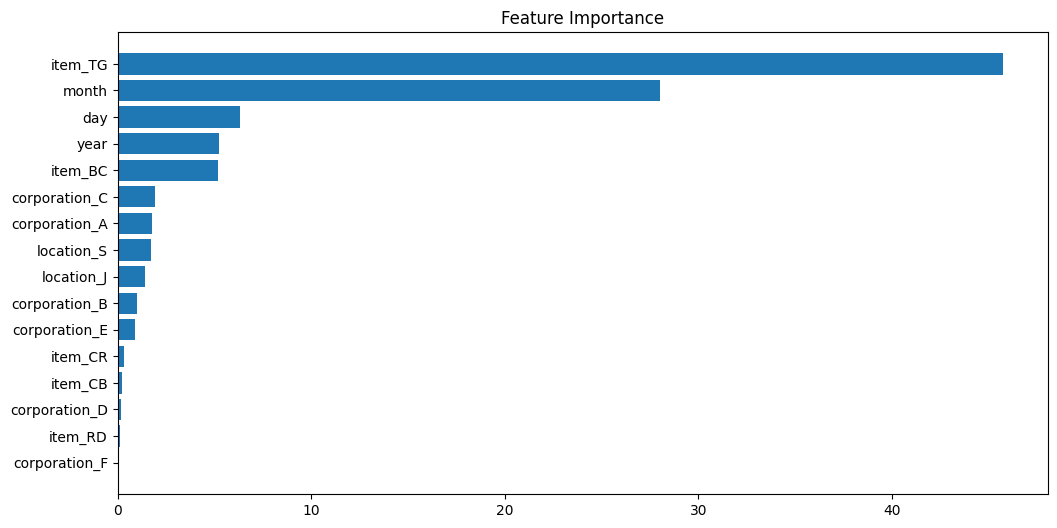

In [81]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
# plt.yticks(range(len(sorted_idx)), np.array(range(len(train_x)))[sorted_idx])
# 변수명이 있다면, 아래와 같이...
plt.yticks(range(len(sorted_idx)), np.array(train_x.columns)[sorted_idx])
plt.title('Feature Importance')

## 랜덤포레스트

### model 1

In [82]:
from sklearn.ensemble import RandomForestRegressor

In [83]:
hp = {
    "random_state": 42,
    "verbose": 0  # 부스팅 단계 출력 안보이게 하기
}
model = RandomForestRegressor(**hp)  # RandomForestRegressor로 모델 변경
n_iter = 0
rmse_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
    n_iter += 1
    # 학습용, 검증용 데이터 구성
    train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
    train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

    # 학습
    model.fit(train_x, train_y)
    valid_pred = model.predict(valid_x)  # 예측값

    # 평가
    rmse = mean_squared_error(valid_y, valid_pred, squared=False)
    rmse_lst.append(rmse)
    print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-' * 50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1175.8736315695007
2 번째 Stratified K-Fold RMSE: 1195.258196628822
3 번째 Stratified K-Fold RMSE: 1182.5754800662025
4 번째 Stratified K-Fold RMSE: 1203.7802903898187
5 번째 Stratified K-Fold RMSE: 1177.844232629002
--------------------------------------------------
교차 검증 RMSE: 1187.066366256669


### model 2

In [84]:
hp = {
    "random_state" : 42,
    "verbose": 0, # 로그
}
model = RandomForestRegressor(**hp)

In [85]:
n_iter=5 # 몇번 hp조합을 찾을 것인가?
scoring = 'neg_root_mean_squared_error' # 어떤 평가지표를 사용할 것인가?
hp={
    "max_depth" : np.linspace(5,12,8,dtype = int), # 깊이
    "n_estimators" : np.linspace(10,500,30, dtype = int), # 부스팅 단계수
}

# HPO 인스턴스 생성
rs1 = RandomizedSearchCV(RandomForestRegressor(), hp, scoring=scoring, n_iter=n_iter, n_jobs=-1, cv=skf, verbose=False)
# 학습 (best hp 조합 찾기)
rs1.fit(train_x, train_y)

# 학습 결과 (best hp 조합일 때,)
rs1.best_score_

-1190.157456398046

In [86]:
best_params = rs1.best_params_
best_params

{'n_estimators': 128, 'max_depth': 11}

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

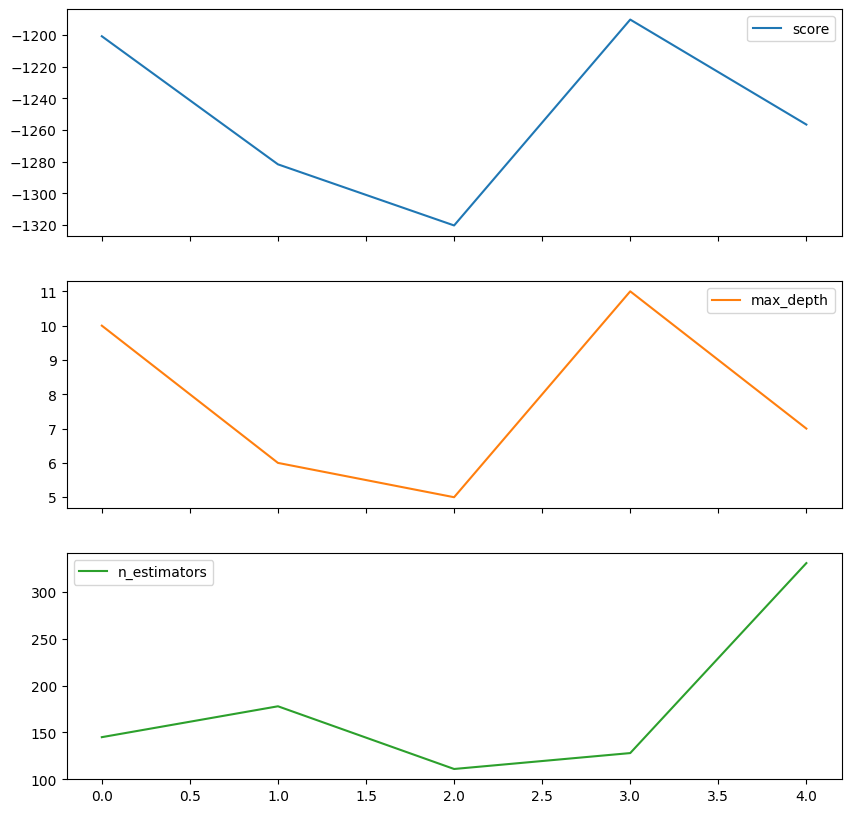

In [87]:
rs_results_df=pd.DataFrame(np.transpose([rs1.cv_results_['mean_test_score'],
                                         rs1.cv_results_['param_max_depth'].data,
                                         rs1.cv_results_['param_n_estimators'].data]),
                           columns=['score', 'max_depth', 'n_estimators'])
rs_results_df.plot(subplots=True,figsize=(10, 10))

In [88]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [89]:
best_params['random_state'] = 42
best_params['verbose'] = 0

# best 모델 인스턴스 생성(정의)
best_model = RandomForestRegressor(**best_params)

In [90]:
n_iter = 0
accuracy_lst = []

for train_index, valid_index in skf.split(train_features, train_target):
  n_iter += 1
  # 학습용, 검증용 데이터 구성
  train_x, valid_x = train_features.iloc[train_index], train_features.iloc[valid_index]
  train_y, valid_y = train_target.iloc[train_index], train_target.iloc[valid_index]

  # 학습
  model.fit(train_x, train_y)
  valid_pred = model.predict(valid_x) # 예측값

  # 평가
  rmse = mean_squared_error(valid_y, valid_pred, squared=False)
  rmse_lst.append(rmse)
  print(f'{n_iter} 번째 Stratified K-Fold RMSE: {rmse}')

# 최종 평가
print('-'*50)
print(f'교차 검증 RMSE: {np.mean(rmse_lst)}')

1 번째 Stratified K-Fold RMSE: 1175.8736315695007
2 번째 Stratified K-Fold RMSE: 1195.258196628822
3 번째 Stratified K-Fold RMSE: 1182.5754800662025
4 번째 Stratified K-Fold RMSE: 1203.7802903898187
5 번째 Stratified K-Fold RMSE: 1177.844232629002
--------------------------------------------------
교차 검증 RMSE: 1187.0663662566692


## 다항 회귀

### model1

In [ ]:
'''from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 예시 데이터 (X는 특성, y는 타겟)
# X = ...
# y = ...

# 다항식 특성 생성
poly = PolynomialFeatures(degree=2)  # 2차 함수를 사용하려면 degree=2로 설정
X_poly = poly.fit_transform(X)

# 다항 회귀 모델 학습
model = LinearRegression()
model.fit(X_poly, y)'''

# train_y, pred RMSE

In [141]:
model

In [142]:
pred = model.predict(train_x)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))
print(f'RMSE: {rmse}')

RMSE: 1116.5985833582627


In [143]:
train_y

,price(원/kg)
0,0.0
1,0.0
2,1728.0
3,1408.0
4,1250.0
...,...
59392,468.0
59393,531.0
59394,574.0
59395,523.0


In [144]:
pred

array([ 416.99484911, -141.53218101,  818.45830679, ...,  670.32087301,
        714.07105987,  624.46707606])

In [145]:
pred_df = pd.DataFrame(pred, columns=['price(원/kg)'])
pred_df

,price(원/kg)
0,416.994849
1,-141.532181
2,818.458307
3,1371.464088
4,996.478590
...,...
47513,547.917423
47514,757.980823
47515,670.320873
47516,714.071060


# 학습 평가

## 산포도

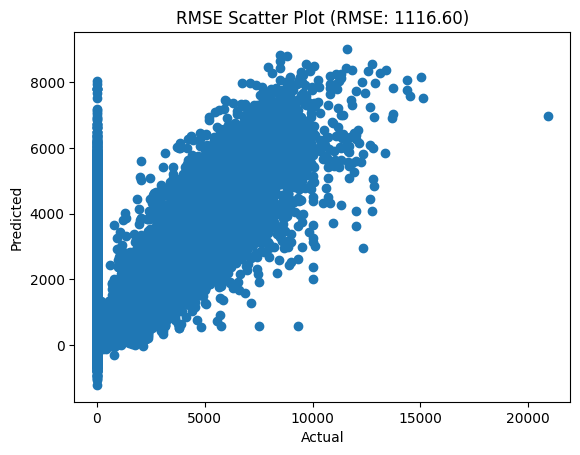

In [146]:
import matplotlib.pyplot as plt

# train_y와 pred의 RMSE를 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 산포도 그래프 생성
plt.scatter(train_y, pred)

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'RMSE Scatter Plot (RMSE: {rmse:.2f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# 그래프 표시
plt.show()

## 예측 오차 히스토그램

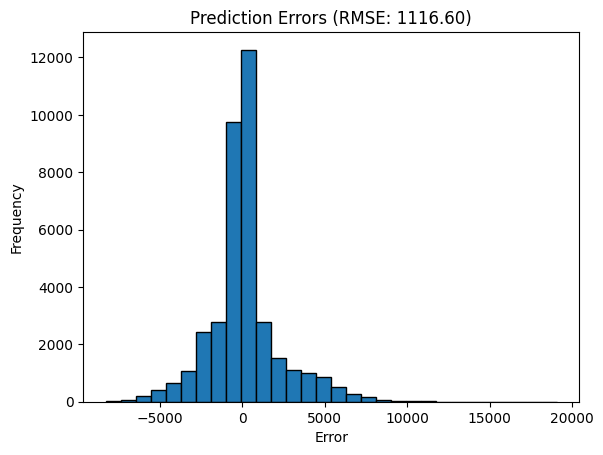

In [147]:
# 예측 오차 계산
errors = train_y - pred_df

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 히스토그램 생성
plt.hist(errors, bins=30, edgecolor='k')

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'Prediction Errors (RMSE: {rmse:.2f})')
plt.xlabel('Error')
plt.ylabel('Frequency')

# 그래프 표시
plt.show()

## 오차의 절대값 히스토그램

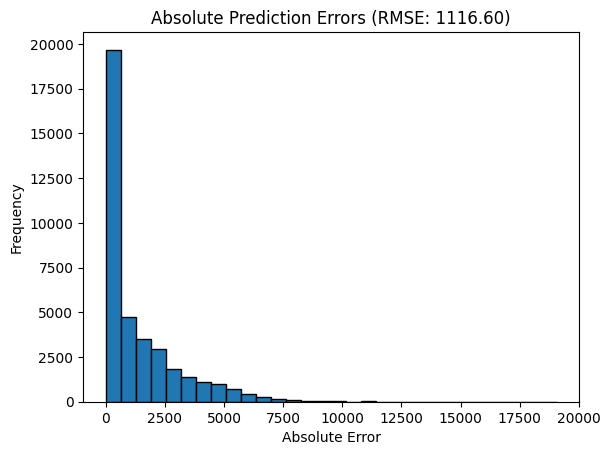

In [148]:
# 예측 오차 계산 (절대값)
errors = np.abs(train_y - pred_df)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred))

# 히스토그램 생성
plt.hist(errors, bins=30, edgecolor='k')

# 그래프에 제목과 x축, y축 레이블 추가
plt.title(f'Absolute Prediction Errors (RMSE: {rmse:.2f})')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')

# 그래프 표시
plt.show()

## 상위 오차 샘플 확인

In [149]:
# 예측 오차 계산
errors = np.abs(train_y['price(원/kg)'] - pred)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(train_y, pred_df))

# 오차와 해당 오차가 속한 샘플의 인덱스를 결합하여 튜플로 만듭니다
error_samples = list(zip(errors, range(len(errors))))

# 오차를 기준으로 정렬합니다 (내림차순)
error_samples.sort(reverse=True, key=lambda x: x[0])

# 상위 N개의 오차 샘플을 확인합니다 (여기서는 상위 10개로 예시)
top_N = 10
top_errors = error_samples[:top_N]



# 결과 출력
for error, sample_idx in top_errors:
    true_value = float(train_y.iloc[sample_idx])
    predicted_value = float(pred[sample_idx])
    print(f'Sample Index: {sample_idx}, Error: {error}, True Value: {true_value:.2f}, Predicted Value: {predicted_value:.2f}')


Sample Index: 5848, Error: 13926.453686099772, True Value: 20909.00, Predicted Value: 6982.55
Sample Index: 11031, Error: 9378.92018533068, True Value: 12333.00, Predicted Value: 2954.08
Sample Index: 10716, Error: 8742.939295007553, True Value: 9333.00, Predicted Value: 590.06
Sample Index: 4966, Error: 8681.789760782496, True Value: 12763.00, Predicted Value: 4081.21
Sample Index: 8001, Error: 8370.309413979468, True Value: 12000.00, Predicted Value: 3629.69
Sample Index: 6180, Error: 8216.400851226223, True Value: 12667.00, Predicted Value: 4450.60
Sample Index: 5870, Error: 8048.489605774882, True Value: 0.00, Predicted Value: 8048.49
Sample Index: 4968, Error: 8021.321718372237, True Value: 12862.00, Predicted Value: 4840.68
Sample Index: 2536, Error: 7994.195919329849, True Value: 10000.00, Predicted Value: 2005.80
Sample Index: 5266, Error: 7952.058343167588, True Value: 0.00, Predicted Value: 7952.06


## Residual Plot

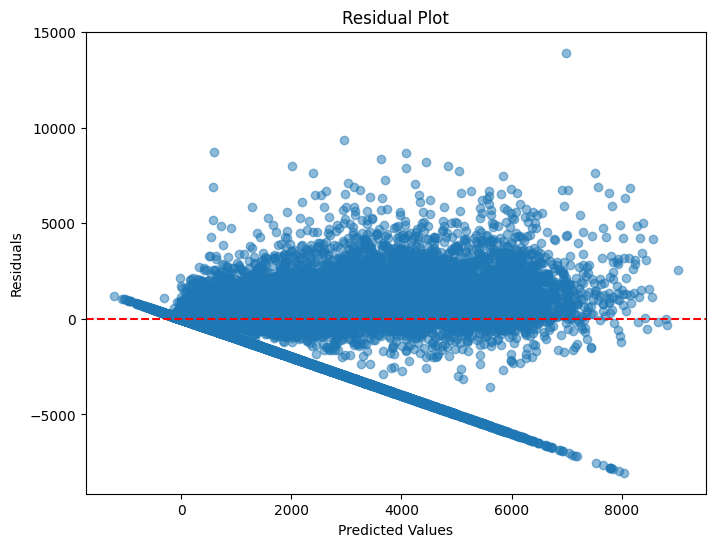

In [150]:
# 예측값과 실제값의 차이 (잔차) 계산
residuals = train_y['price(원/kg)'] - pred

# Residual Plot 그리기
plt.figure(figsize=(8, 6))
plt.scatter(pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

# Submission

In [151]:
submission = pd.read_csv('./sample_submission.csv')
submission

,ID,answer
0,TG_A_J_20230304,0
1,TG_A_J_20230305,0
2,TG_A_J_20230306,0
3,TG_A_J_20230307,0
4,TG_A_J_20230308,0
...,...,...
1087,RD_F_J_20230327,0
1088,RD_F_J_20230328,0
1089,RD_F_J_20230329,0
1090,RD_F_J_20230330,0


In [152]:
target_pred = model.predict(test_encoded)

In [153]:
submission['answer'] = target_pred
submission

,ID,answer
0,TG_A_J_20230304,3148.892305
1,TG_A_J_20230305,2408.686634
2,TG_A_J_20230306,2650.847075
3,TG_A_J_20230307,3151.705743
4,TG_A_J_20230308,3382.413498
...,...,...
1087,RD_F_J_20230327,578.904067
1088,RD_F_J_20230328,796.743179
1089,RD_F_J_20230329,235.409781
1090,RD_F_J_20230330,1227.112155


In [108]:
submission.to_csv('./Hyul.csv', index=False)